In [64]:
import pandas as pd
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# loading data

In [65]:
data1 = pd.read_csv('Playstore_final.csv', encoding='utf-8')
data2 = pd.read_csv('GooglePlay.csv')

<ipython-input-65-e04bc9b27d18>:1: DtypeWarning: Columns (7,12,20,21,29,30,33,35,37,38,40,42,43,44,46,47,48,49,50,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data1 = pd.read_csv('Playstore_final.csv', encoding='utf-8')


# Handling missing values

# Cleaning data

In [66]:
def remove_character(data, replacements):
    for column, characters in replacements:
        data[column] = data[column].str.replace(characters, '')
    return data

def change_data_type(data,colmns_type):
    for col , data_type in colmns_type:
        if data[col].dtype == 'object':
            data[col] = pd.to_numeric(data[col], errors='coerce')
            data[col] = data[col].astype(data_type)
    return data

data1 = remove_character(data1, [('Size','M'),('Installs','+'),('Installs' , ',')])
data1 = change_data_type(data1, [('Size','Float64'),('Installs','Float64'),('Installs' , 'Float64')])

data2 = remove_character(data2 , [('Size','M'), ('Installs','+'),('Installs' , ',')])
data2 = change_data_type (data2 , [('Size','Float64'),('Reviews','Float64'),('Installs' , 'Float64') , ('Price' ,'Float64' )] )

In [67]:
from datetime import datetime, timedelta

def parse_date(date):
    try:
        return pd.to_datetime(date, format='%d-%b-%y')
    except ValueError:
        return np.nan

data1['Released'] = data1['Released'].apply(parse_date)
data1['Last update'] = data1['Last update'].apply(parse_date)
data2['Last Updated'] = data2['Last Updated'].apply(parse_date)



### removing records with more than X null values

In [68]:
data2 = data2[data2.isnull().sum(axis=1) <= 2]
data2.isna().sum()

Unnamed: 0           0
App                  0
Category             0
Rating            1444
Reviews              0
Size              1981
Installs             0
Type                 0
Price              773
Content Rating       0
Genres               0
Last Updated         0
Current Ver          5
Android Ver          2
dtype: int64

### Filling NuLL Value with the mean of a column

In [69]:
def fill_nulls (data , collumns , fillig_type):
    X = data[collumns].mean()

    if fillig_type == 'mean':
        X = data[collumns].mean()
    elif fillig_type == 'max':
        X = data[collumns].max()
    elif fillig_type == 'mode':
        X = data[collumns].mode()
    data[collumns] = data[collumns].fillna(X)
    return data

data1 = fill_nulls(data1 , ['Price', 'Rating Count', 'Size','Installs'] ,  'mean')
data2 = fill_nulls(data2 , ['Size' ,'Price'] , 'mean')

<ipython-input-69-867dede45128>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[collumns] = data[collumns].fillna(X)


### using regression to fill null values

In [11]:

def fill_with_regression(orig_data ,column_to_fill , other_numeric_columns ):
    data = orig_data[other_numeric_columns]
    X = data.dropna(subset=[column_to_fill])
    X = X.drop(columns=[column_to_fill])
    y = data.dropna(subset=[column_to_fill])[column_to_fill]

    regressor = LinearRegression()
    regressor.fit(X, y)

    X_missing = data[data[column_to_fill].isnull()].drop(columns=[column_to_fill])
    predicted_values = regressor.predict(X_missing)

    data.loc[data[column_to_fill].isnull(), column_to_fill] = predicted_values
    orig_data[column_to_fill] = data[column_to_fill]
    return orig_data

data1 = fill_with_regression(data1 , 'Rating' ,  ['Rating', 'Price','Rating Count', 'Size','Installs'] )
data2 = fill_with_regression(data2 , 'Rating' , ['Rating', 'Price','Reviews', 'Size','Installs'] )

## data conversion

### normalizing the data

In [70]:
def data_normalizer(data , columns_to_normalize ):
    scaler = MinMaxScaler()
    data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
    return data

data1 = data_normalizer(data1 , ['Rating', 'Minimum Installs', 'Price','Minimum Installs','Reviews','Installs','Rating Count'])
data2 = data_normalizer(data2 , ['Rating', 'Price','Reviews', 'Size','Installs'])

In [71]:
data1.head(10)

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Free,Price,Currency,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56
0,Logistics Management,com.eniseistudio.logistics_management,Education,0.818182,4.545082e-07,1.000000e-06,1.000000e-06,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Estados Unidos Noticias,com.eniseistudio.news.estados_unidos,News & Magazines,0.800000,3.607208e-08,1.000000e-07,1.000000e-07,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Dental Assistant,com.eniseistudio.dental_assistant,Education,0.773333,8.657298e-08,1.000000e-06,1.000000e-06,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Medical Assistant,com.eniseistudio.course.medical_assistant,Education,0.800000,1.082162e-07,5.000000e-07,5.000000e-07,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Business Administration,com.eniseistudio.majors.course.business_admini...,Education,0.804651,5.987965e-07,5.000000e-06,5.000000e-06,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Economics,com.eniseistudio.economics,Education,0.827723,1.587171e-06,1.000000e-05,1.000000e-05,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Cosmetology,com.eniseistudio.course.cosmetology,Education,0.484211,1.154306e-07,5.000000e-07,5.000000e-07,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Learn Python,com.jquiz.python,Education,0.000000,1.389986e-04,1.000000e-09,1.000000e-09,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Quality Management,com.eniseistudio.quality_management,Education,0.866667,2.164325e-08,5.000000e-07,5.000000e-07,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Tourism Management,com.eniseistudio.tourism_management,Education,0.946154,1.659315e-07,1.000000e-06,1.000000e-06,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# making new features

In [72]:
import pandas as pd
import numpy as np
# new feature from Installs and Rating Count
data1['Engagement_Score'] = np.log(data1['Installs']) * np.log(data1['Rating Count'])

data1[['Installs', 'Rating Count', 'Engagement_Score']].head(10)


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Installs,Rating Count,Engagement_Score
0,1.000000e-06,4.545082e-07,201.762407
1,1.000000e-07,3.607208e-08,276.227842
2,1.000000e-06,8.657298e-08,224.671674
3,5.000000e-07,1.082162e-07,232.706313
4,5.000000e-06,5.987965e-07,174.892809
5,1.000000e-05,1.587171e-06,153.738508
6,5.000000e-07,1.154306e-07,231.769946
7,1.000000e-09,1.389986e-04,184.044291
8,5.000000e-07,2.164325e-08,256.057097
9,1.000000e-06,1.659315e-07,215.683475


# removing outlier records

In [73]:
def remove_outliers(data, columns, threshold=1.5):

    cleaned_data = data.copy()
    for column in columns:
        Q1 = cleaned_data[column].quantile(0.25)
        Q3 = cleaned_data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        cleaned_data = cleaned_data[(cleaned_data[column] >= lower_bound) & (cleaned_data[column] <= upper_bound)]
    return cleaned_data

data1 = remove_outliers(data1 , ['Rating','Size' ,'Installs' ] , threshold=3)
data2 = remove_outliers(data2 , ['Rating', 'Price','Reviews', 'Size','Installs'] , threshold = 3)

In [74]:
#old approach to removing outliers
# import pandas as pd
# import numpy as np
# from scipy import stats

# threshold = 3

# z_scores_rating = np.abs((data1['Rating'] - data1['Rating'].mean()) / data1['Rating'].std())
# z_scores_size = np.abs((data1['Size'] - data1['Size'].mean()) / data1['Size'].std())
# z_scores_installs = np.abs((data1['Installs'] - data1['Installs'].mean()) / data1['Installs'].std())

# combined_mask = (z_scores_rating < threshold) | (z_scores_size < threshold) | (z_scores_installs < threshold)
# data1 = data1[combined_mask]


# convert numerical data to categorical

In [ ]:
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder

# selected_columns = ['Rating', 'Rating Count', 'Installs', 'Price','Content Rating']
# X = data1[selected_columns]

# label_encoder = LabelEncoder()

# for col in X.columns:
#     X[col] = label_encoder.fit_transform(X[col])

# X.head(10)


# Comparison between Sport Apps Rating with oveerall rating



In [75]:
import pandas as pd
from scipy.stats import ttest_ind


sports_ratings = data1[data1['Category'] == 'Sports']['Rating']

overall_avg_rating = data1['Rating'].mean()

t_statistic, p_value = ttest_ind(sports_ratings, data1['Rating'])

if p_value < 0.05:
    print("There is a significant difference between sports app ratings and overall average rating.")
else:
    print("No significant difference found.")

print(f"Sports Apps Average Rating: {sports_ratings.mean()}")
print(f"Overall Average Rating: {overall_avg_rating:.2f}")


No significant difference found.
Sports Apps Average Rating: 0.5865478183268984
Overall Average Rating: 0.58


# data reduction


### Dimensionality Reduction

In [76]:
data1 = data1[['App Name', 'App Id', 'Category', 'Rating', 'Rating Count', 'Installs',
       'Minimum Installs', 'Free', 'Price', 'Currency', 'Size',
       'Minimum Android', 'Developer Id', 'Released', 'Last update', 'Content Rating', 'Reviews']]
data2 = data2[[ 'App', 'Category', 'Rating', 'Reviews', 'Size',
       'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated',
       'Current Ver', 'Android Ver']]

In [77]:
pca = PCA(n_components=2)

selected_columns = ['Rating', 'Rating Count', 'Installs','Price']
X = data1[selected_columns]

principal_components = pca.fit_transform(X)

df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# data visualization

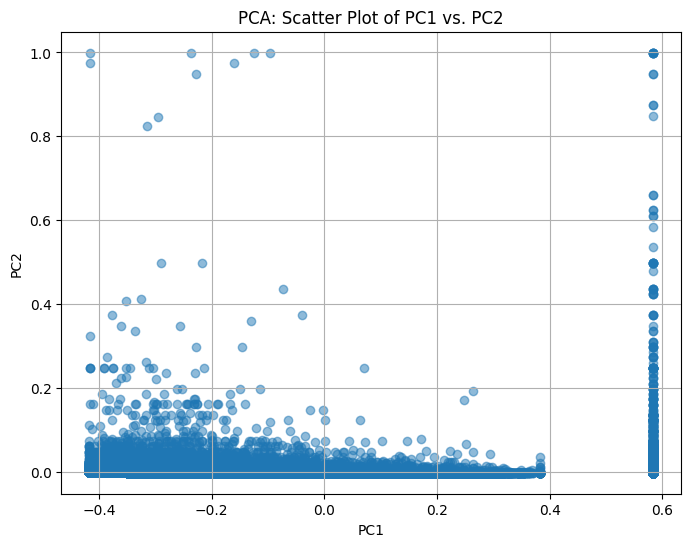

In [78]:

plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: Scatter Plot of PC1 vs. PC2')
plt.grid(True)
plt.show()

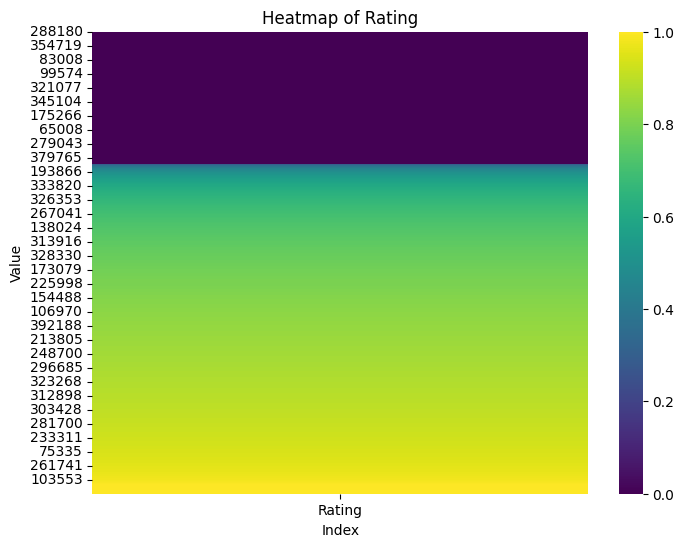

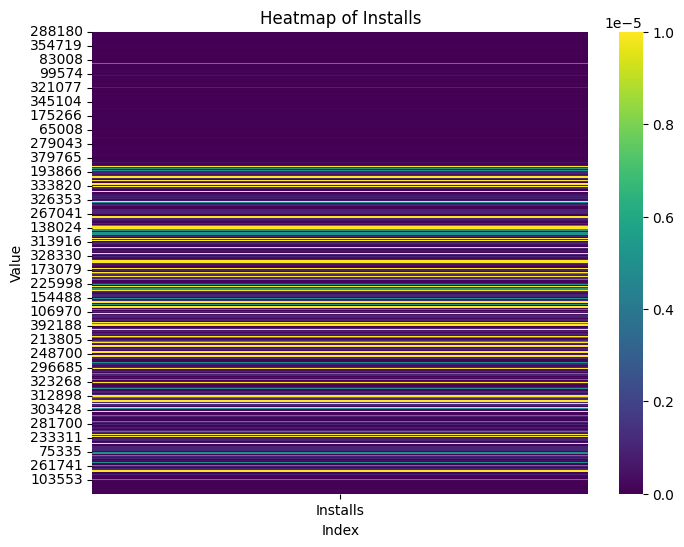

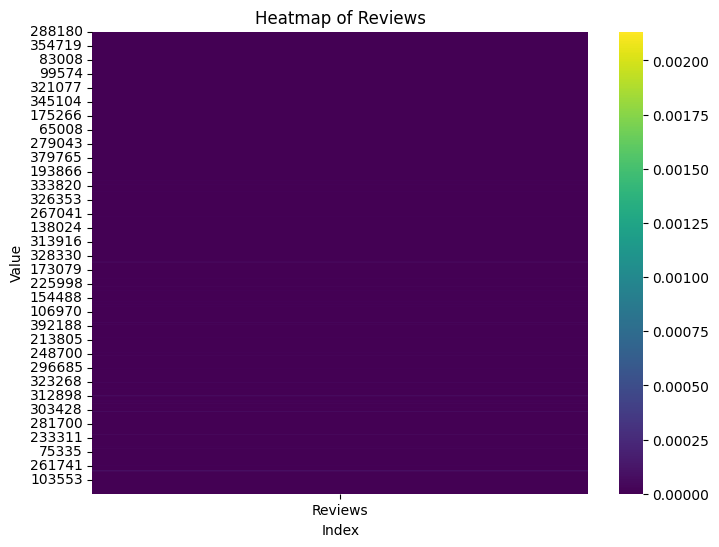

In [79]:
import matplotlib.pyplot as plt

columns = ['Rating', 'Installs','Reviews']
sort_by='Rating'
sorted_data = data1.sort_values(by=sort_by , ascending=True)

for col in columns:
    plt.figure(figsize=(8, 6))
    sns.heatmap(sorted_data[[col]], cmap='viridis', annot=False)
    plt.title(f'Heatmap of {col}')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

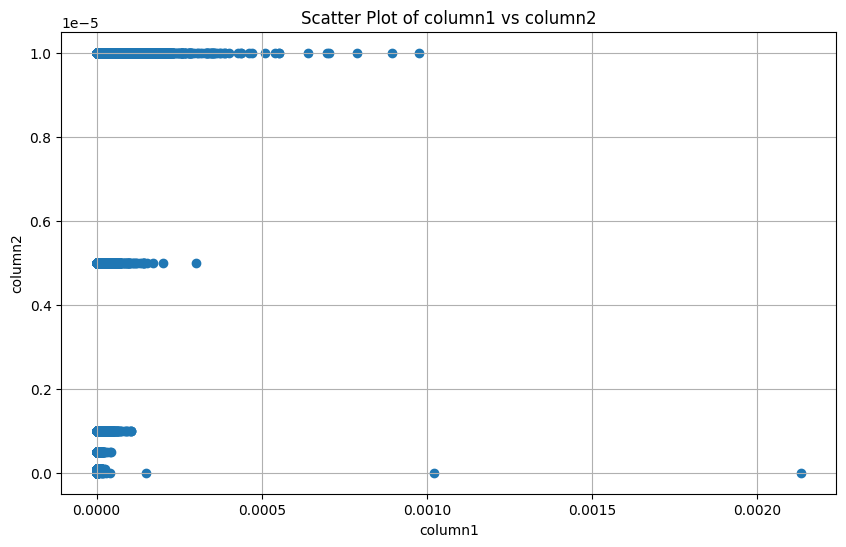

In [80]:
plt.figure(figsize=(10, 6))
plt.scatter(data1['Reviews'], data1['Installs'])
plt.title('Scatter Plot of column1 vs column2')
plt.xlabel('column1')
plt.ylabel('column2')
plt.grid(True)
plt.show()

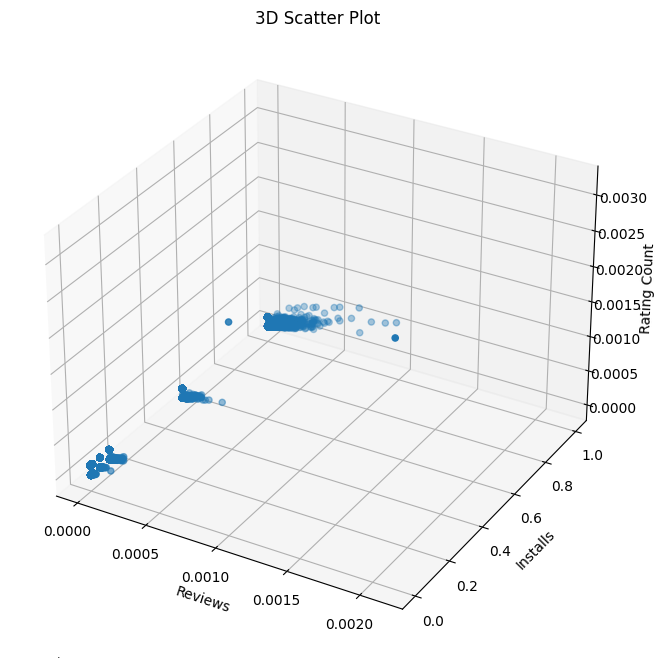

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



# Extract the three columns you want to visualize
x = data1['Reviews']
y = data1['Installs']
z = data1['Rating Count']

# Create a new figure and axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the points
ax.scatter(x, y, z)

# Set labels and title
ax.set_xlabel('Reviews')
ax.set_ylabel('Installs')
ax.set_zlabel('Rating Count')
ax.set_title('3D Scatter Plot')

plt.show()


# data aggregation

### assimilating related columns names

In [82]:
data2 = data2.rename(columns={'App': 'App Name'})
data2 = data2.rename(columns={'Type' :'Free'})
data1 = data1.rename(columns={'Last update' :'Last Updated'})
data1 = data1.rename(columns={'Category' :'Genres'})


### assimilating  related columns data type

In [83]:
data2['Free'] = data2['Free'].replace({'Pain': False, 'Free': True})

In [84]:
merged_df = pd.merge(data2, data1, on=['App Name','Genres'], how='left', suffixes=('_d2', '_d1'))


In [85]:
merged_df.head(10)

,App Name,Category,Rating_d2,Reviews_d2,Size_d2,Installs_d2,Free_d2,Price_d2,Content Rating_d2,Genres,...,Free_d1,Price_d1,Currency,Size_d1,Minimum Android,Developer Id,Released,Last Updated_d1,Content Rating_d1,Reviews_d1
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,0.775,0.000002,0.181818,0.00001,True,0.0,Everyone,Art & Design,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaT,NaT,NaN,NaN
1,Coloring book moana,ART_AND_DESIGN,0.725,0.000012,0.131313,0.00050,True,0.0,Everyone,Art & Design;Pretend Play,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaT,NaT,NaN,NaN
2,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,0.825,0.000012,0.018182,0.00010,True,0.0,Everyone,Art & Design;Creativity,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaT,NaT,NaN,NaN
3,Paper flowers instructions,ART_AND_DESIGN,0.850,0.000002,0.046465,0.00005,True,0.0,Everyone,Art & Design,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaT,NaT,NaN,NaN
4,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,0.700,0.000002,0.181818,0.00005,True,0.0,Everyone,Art & Design,...,True,0.0,USD,19.0,4.0.3,Anzu+Dev,2018-04-26,2018-04-26,Everyone,0.000009
5,Infinite Painter,ART_AND_DESIGN,0.775,0.000471,0.282828,0.00100,True,0.0,Everyone,Art & Design,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaT,NaT,NaN,NaN
6,Garden Coloring Book,ART_AND_DESIGN,0.850,0.000176,0.323232,0.00100,True,0.0,Everyone,Art & Design,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaT,NaT,NaN,NaN
7,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,0.925,0.000002,0.021212,0.00001,True,0.0,Everyone,Art & Design;Creativity,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaT,NaT,NaN,NaN
8,Text on Photo - Fonteee,ART_AND_DESIGN,0.850,0.000178,0.272727,0.00100,True,0.0,Everyone,Art & Design,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaT,NaT,NaN,NaN
9,Name Art Photo Editor - Focus n Filters,ART_AND_DESIGN,0.850,0.000112,0.111111,0.00100,True,0.0,Everyone,Art & Design,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaT,NaT,NaN,NaN


In [86]:
def merge_column(data ,columns):
    for column in columns:
        # if two column ore equal or _d1 is null
        data[column] = data.apply(lambda row: row[column+'_d2'] if (not pd.notna(row[column+'_d1']) ) or
                                            row[column+'_d2'] == row[column+'_d1'] else np.nan, axis=1)
        # if both column are not null but both hase different values
        # we chose date from newest dataset
        data[column] = data.apply(lambda row: row[column+'_d1'] if row['Last Updated_d1'] >=
                                            row['Last Updated_d2'] else row[column], axis=1)
        data.pop(column + '_d1')
        data.pop(column + '_d2')

    return data
merged_df = merge_column(merged_df , ['Size','Price' , 'Rating' , 'Reviews' , 'Installs','Free'])


In [87]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6458 entries, 0 to 6457
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   App Name           6458 non-null   object        
 1   Category           6458 non-null   object        
 2   Content Rating_d2  6458 non-null   object        
 3   Genres             6458 non-null   object        
 4   Last Updated_d2    6458 non-null   datetime64[ns]
 5   Current Ver        6454 non-null   object        
 6   Android Ver        6456 non-null   object        
 7   App Id             1060 non-null   object        
 8   Rating Count       1060 non-null   float64       
 9   Minimum Installs   1060 non-null   float64       
 10  Currency           1060 non-null   object        
 11  Minimum Android    1059 non-null   object        
 12  Developer Id       1060 non-null   object        
 13  Released           1006 non-null   datetime64[ns]
 14  Last Upd

In [88]:
merged_df.head(30)

,App Name,Category,Content Rating_d2,Genres,Last Updated_d2,Current Ver,Android Ver,App Id,Rating Count,Minimum Installs,...,Developer Id,Released,Last Updated_d1,Content Rating_d1,Size,Price,Rating,Reviews,Installs,Free
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,0.181818,0.0,0.775000,2.034333e-06,1.000000e-05,True
1,Coloring book moana,ART_AND_DESIGN,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,0.131313,0.0,0.725000,1.237233e-05,5.000000e-04,True
2,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4 and up,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,0.018182,0.0,0.825000,1.237233e-05,1.000000e-04,True
3,Paper flowers instructions,ART_AND_DESIGN,Everyone,Art & Design,2017-03-26,1,2.3 and up,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,0.046465,0.0,0.850000,2.136689e-06,5.000000e-05,True
4,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,Everyone,Art & Design,2018-04-26,1.1,4.0.3 and up,com.devanzu.smokeeffectphotomaker.smokeeditor,8.015215e-06,1.000000e-05,...,Anzu+Dev,2018-04-26,2018-04-26,Everyone,19.000000,0.0,0.612613,8.553340e-06,1.000000e-05,True
5,Infinite Painter,ART_AND_DESIGN,Everyone,Art & Design,2018-06-14,6.1.61.1,4.2 and up,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,0.282828,0.0,0.775000,4.710312e-04,1.000000e-03,True
6,Garden Coloring Book,ART_AND_DESIGN,Everyone,Art & Design,2017-09-20,2.9.2,3.0 and up,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,0.323232,0.0,0.850000,1.764496e-04,1.000000e-03,True
7,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,Everyone,Art & Design;Creativity,2018-07-03,2.8,4.0.3 and up,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,0.021212,0.0,0.925000,1.548140e-06,1.000000e-05,True
8,Text on Photo - Fonteee,ART_AND_DESIGN,Everyone,Art & Design,2017-10-27,1.0.4,4.1 and up,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,0.272727,0.0,0.850000,1.775883e-04,1.000000e-03,True
9,Name Art Photo Editor - Focus n Filters,ART_AND_DESIGN,Everyone,Art & Design,2018-07-31,1.0.15,4.0 and up,NaN,NaN,NaN,...,NaN,NaT,NaT,NaN,0.111111,0.0,0.850000,1.124385e-04,1.000000e-03,True


In [90]:
# filling nulls:
merged_df = fill_nulls(merged_df , ['Price', 'Rating Count', 'Size','Installs',] ,  'mean')

# normalization:
merged_df = data_normalizer(merged_df , ['Rating', 'Minimum Installs', 'Price','Minimum Installs','Reviews','Installs','Rating Count'])

# removing outliers:
merged_df = remove_outliers(merged_df , ['Rating','Size' ,'Installs' ] , threshold=3)

# new feature from Installs and Rating Count
merged_df['Engagement_Score'] = np.log(merged_df['Installs']) * np.log(merged_df['Rating Count'])

merged_df[['Installs', 'Rating Count', 'Engagement_Score']].head(10)


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Installs,Rating Count,Engagement_Score
0,0.009999,0.388157,4.358176
1,0.499999,0.388157,0.655958
2,0.099999,0.388157,2.179050
3,0.049999,0.388157,2.835016
5,1.000000,0.388157,-0.000000
6,1.000000,0.388157,-0.000000
7,0.009999,0.388157,4.358176
8,1.000000,0.388157,-0.000000
9,1.000000,0.388157,-0.000000
10,0.099999,0.388157,2.179050


In [96]:
# creating nominal featrure out of "Rating"
bins = [0, 0.3, 0.6, 0.9, 1]
labels = ['Bad', 'Medium', 'Good', 'Perfect']
merged_df['Rating_category'] = pd.cut(merged_df['Rating'], bins=bins, labels=labels)

merged_df[['Rating', 'Rating_category']]

,Rating,Rating_category
0,0.64,Good
1,0.56,Medium
2,0.72,Good
3,0.76,Good
5,0.64,Good
...,...,...
6452,0.52,Medium
6453,0.92,Perfect
6454,0.60,Good
6456,1.00,Perfect
